function to compute numpy representation from video file (thanks Yana!)

In [1]:
import numpy as np
import cv2
import os.path

# trs, let's assume width is always wider than height
def video_to_npy(infile, outfile=None, width=None, height=None, squarecrop=None, fps=None, cropat=None):
    
    # has this video already been saved before?
    if isfile(outfile):
        frames = np.load(outfile)
        if frames.shape[1]==height:
            # just return this preloaded video
            return frames
    
    print('reading fresh video from %s' % infile)
    vidcap = cv2.VideoCapture(infile)
    success, image = vidcap.read()
    
    frames = []
    count = 0
    if not success:
        raise ValueError('Could not read the video file!')
    while success:
        frames.append( image[...,::-1] )
        count += 1
        success,image = vidcap.read()
    if fps:
        span = int(vidcap.get(cv2.CAP_PROP_FPS) / fps)
        frames = frames[0::span] 
    if width or height:  
        width = width if width else int(height / frames[0].shape[0] * frames[0].shape[1])
        height = height if height else int(width / frames[0].shape[1] * frames[0].shape[0])
        frames = [ cv2.resize(frame, (width, height)) for frame in frames ]
    if squarecrop:
        tl = int((width/2)-(height/2))
        # note that x,y is the wrong way around i.e. it's
        # F x Y x X x C
        frames = [ frame[ 0:height, tl:(tl+height)] for frame in frames ]
    if cropat:
        frames = frames[0:cropat*fps]
        
    frames = np.array(frames)
    if outfile:
        np.save(outfile, frames)
    return frames

In [2]:
from random import shuffle
from pipe import *

@Pipe
def pshuffle(l):
    shuffle(l)
    return l
@Pipe
def pcycle(l):
    return cycle(l)

In [3]:
from os import listdir
from os.path import isfile, join
from itertools import *
from pipe import *

# return iterable { (label, path/video1), (label, path/video2), ... }
def GetVideos( path, label, ext='.mp4' ):
    p = listdir(path) | where( lambda p: p.endswith(ext) ) | as_list()
    return zip( repeat(label, len(p)), map( lambda p: join( path, p ), p ) )

In [4]:
import pickle
# dump a classes file so the others can see which classes I have assigned

classes = GetVideos('./videos/collisions', 1) \
    | chain_with(GetVideos('./videos/not-collisions', 0))  \
    | select( lambda i: (i[1].replace('./videos/collisions\\','').replace('./videos/not-collisions\\',''), i[0]) ) \
    | as_dict()

pickle.dump( classes, open( "class_structure.p", "wb" ) ) 

classes

{'output000-26961.mp4': 1,
 'output000-5404.mp4': 1,
 'output000.mp4': 1,
 'output001-24132.mp4': 1,
 'output001-24962.mp4': 1,
 'output001-5404.mp4': 1,
 'output001.mp4': 1,
 'output002-26961.mp4': 1,
 'output002-27378.mp4': 1,
 'output002-4994.mp4': 1,
 'output002-5404.mp4': 1,
 'output002.mp4': 1,
 'output003-24962.mp4': 1,
 'output003-26961.mp4': 1,
 'output003-27378.mp4': 1,
 'output003-5404.mp4': 1,
 'output003.mp4': 1,
 'output004-27378.mp4': 1,
 'output004-31027.mp4': 1,
 'output004-4994.mp4': 1,
 'output004-5404.mp4': 1,
 'output004.mp4': 1,
 'output005-26961.mp4': 1,
 'output005-4360.mp4': 1,
 'output005-5404.mp4': 1,
 'output005.mp4': 1,
 'output006-24132.mp4': 1,
 'output006-24962.mp4': 1,
 'output006-26961.mp4': 1,
 'output006-27378.mp4': 1,
 'output006-4994.mp4': 1,
 'output006-5404.mp4': 1,
 'output006.mp4': 1,
 'output007-24962.mp4': 1,
 'output007-26961.mp4': 1,
 'output007-31027.mp4': 1,
 'output007-4360.mp4': 1,
 'output007-5404.mp4': 1,
 'output007.mp4': 1,
 'output

In [5]:
import uuid
import pickle
import math

collisions = GetVideos('./videos/collisions', 1) | as_list() | pshuffle()
ncollisions = GetVideos('./videos/not-collisions', 0) | as_list() | pshuffle()

# what is the min number in either class?
minn = [ collisions | count, ncollisions | count ] | min

# now let's validate on 33% of that
vs = math.floor( minn * 0.33 )

In [6]:
# run this when you need to
#valset = collisions | take(vs) | chain_with( ncollisions | take(vs) ) | as_list()
# let's save this valsplit to the filesystem for use later!
#pickle.dump( valset, open( "valsplit_%s.p" % uuid.uuid4().hex, "wb" ) ) 

In [7]:
# are you running this later and want to pick up from a previous val split for consistent results?
# important; has the population of videos on the file system changed since this pickle was created?
import pickle
valset = pickle.load( open( "valsplit_1b46b8e12c244afdaf09f83241fb443a.p", "rb" ) )

In [8]:
# how many validation videos?
print(valset | count)

118


In [15]:
# now let's get a stream of train and validation videos which is label-balanced 

def videoStream():
    # handy dict to see if a file is in the validation set
    vd = valset | select( lambda t: (t[1],t[0]) ) | as_dict()
    
    
    while True:
        
        #create an infinite sequence of both, taking the same from both to ensure 
        # same average label distribution
        ic = collisions | where( lambda v: v[1] not in vd ) | as_list() | pshuffle() | take(100)
        inc = ncollisions | where( lambda v: v[1] not in vd ) | as_list() | pshuffle() | take(100)

        mixed_stream = ( ic \
            | chain_with( inc )  \
            | as_list()
            # shuffle it so we get good label mix
            | pshuffle() )
        
        for e in mixed_stream:
            yield e

In [17]:
# this is our training stream which is label balanced
stream = videoStream()

In [18]:
# check no leakage between val set and training stream!
fir = valset | first()

for i in range(400):
    s = next(stream)
    print( '%s!=%s' % ( s[1],fir[1]  ) )
    assert( s[1] is not fir[1] )

./videos/not-collisions\output440-14767.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\output008-14767.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output121.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\output110.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\output651-14767.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output039-5404.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output054-24962.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output044-4994.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output000-26961.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output002-26961.mp4!=./videos/collisions\output003.mp4
./videos/not-collisions\output646-14767.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output017-5404.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output058.mp4!=./videos/collisions\output003.mp4
./videos/collisions\output

for every video in the collisions/non collisions folder, compute the numpy representation 

In [19]:
# adorn the video to the tuple iterator, return cloned+appended tuple
@Pipe
def adornVideo(iterator, framerate=25, video_size=64, max_length=5):
    return iterator \
        | select( lambda f: f + ( 
            video_to_npy( f[1], 
                         #note weird thing here, width doesn't work they appear to be inverted
                         height=video_size, 
                         squarecrop=True, 
                         fps=framerate,
                         cropat=max_length,
                         # save a npy replacement
                         outfile=f[1].replace('.mp4','_%d.npy' % (video_size) )
            ), ) )


ok, so at this point we now have a numpy array for every single video file! the numpy arrays are fixed on some video size, length and frame rate i.e. 200^2, 5 seconds and 25fps.  

For every single video file, we compute a random augmentation consistently across all of the frames

In [20]:
import random

from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=5,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)

@Pipe
def augmentation( 
    flow,
    colpath='./collisions',
    noncolpath='./not-collisions',
    augment=True, 
    diff=False,
    normalize=True):
   
    for video in flow:
        # for every frame in this video generate the same transformation
        # and yield it all back in sequence order
        trans = image_datagen.get_random_transform(video[2].shape)
        augmentedVideo = np.zeros( video[2].shape )
        for i in range(video[2].shape[0]):
            if augment:
                augmentedVideo[i] = image_datagen.apply_transform(video[2][i], trans)
            else:
                augmentedVideo[i] = video[2][i]
            
            # now is a good time to transform the video onto 0-1
            # we need to do this to get convergence when we train i.e. homogenise features
            if normalize:
                augmentedVideo[i] = augmentedVideo[i] / 255
            
            # take xth order differences of frames to convey pixel-wise temporal changes
            if diff is not None:
                augmentedVideo[i, 0:augmentedVideo[i].shape[0]-diff] = np.diff(augmentedVideo[i], axis=0, n=diff)
            
        yield video[:-1] + (augmentedVideo,)


Using TensorFlow backend.


let's visualize the augmented results for this video

In [21]:
import matplotlib.pyplot as plt

def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.xticks([]), plt.yticks([])
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.tight_layout()
    plt.show()
    display()

In [ ]:
train_withvideo_aug = stream |  adornVideo() | augmentation(diff=None, augment=True)
val_withvideo = valset | adornVideo()

def getTestImages(flow, howmany=5):
    augmentedVideo = next(flow)
    print(augmentedVideo[2].shape)
    return range(augmentedVideo[2].shape[0]) \
        | select( lambda i: augmentedVideo[2][i] ) \
        | take(howmany) 

# show some augmented train images
images = getTestImages(train_withvideo_aug)

for x in range(2):
    images = images | chain_with( getTestImages(train_withvideo_aug) )

show_images( images | as_list, cols=4 )

# and do the same for some validation images
images = getTestImages(val_withvideo)
for x in range(2):
    images = images | chain_with( getTestImages(val_withvideo) )

show_images( images | as_list, cols=4 )

ok this is looking pretty good, next thing is to zeropad so that the number of frames is always the same i.e. max seconds * framerate

In [22]:
@Pipe
def zeroPadVideos(videoStream, video_size=64, max_length=5, framerate=25):
    for video in videoStream:
        zeroPadded = np.zeros( ( max_length * framerate, video_size, video_size, 3 ) )
        zeroPadded[ 0:video[2].shape[0], :, : ,: ] = video[2]
        yield video[:-1] + (zeroPadded,)

# we will need to do the same thing to the validation stream as what happened to the train stream!
@Pipe
def normalizeVideos(videoStream):
    for video in videoStream:
        
        yield ( video[0], video[1], video[2]/255  )

OK the next problem is we have a nice generator for videos, but we are doing a 4d CNN with videos and need a batch dimension, so let's write another generator which will batch X videos at a time

```
next( zeroPadVideos( flow ) )[3].shape
```
== (125, 200, 200, 3)


In [24]:
@Pipe
def getBatchVideosFlow(flow, batchsize=10, video_size=64, max_length=5, framerate=25):
    while(True):
        batch = np.zeros( (batchsize, max_length * framerate, video_size, video_size, 3 ) )
        labels = np.zeros( (batchsize,1))
        for i in range(batchsize):
            video = next( flow )
            batch[i] = video[2]
            labels[i] = video[0]
        yield ( batch, labels )

We now have a generator giving us batches of training examples and respective labels, we can feed this into keras fit_generator!

How big is a batch i.e. will it fit in memory?

In [25]:
%%time
from sys import getsizeof

g = train_withvideo_aug = stream \
    |  adornVideo()  \
    | augmentation(diff=None, augment=True)  \
    | zeroPadVideos()  \
    |  getBatchVideosFlow(5)

r = next( g )
# signals one for each video
print(r[0].shape)
# labels one for each video
print(r[1].shape)

print(getsizeof(r[0])/1024**3)
# == 2.4gb for 20 videos of 125 frames @ 200^2*3

# clear r
r=0

(5, 125, 64, 64, 3)
(5, 1)
0.05722060799598694
Wall time: 346 ms


now let's try and train keras on it

In [149]:
video_size = 64
framerate = 25
max_length = 5
batchsize = 10

print('training with videosize: %s framerate: %d' % (video_size, framerate))

# make a fresh stream for clarity
train_stream = ( videoStream() 
    # actually load the respective video into memory
    | adornVideo(framerate=framerate, video_size=video_size, max_length=max_length) 
    # for all frames in this video, randomly augment them in the same way
    | augmentation(diff=False, augment=True, normalize=True) 
    #| normalizeVideos()
    | zeroPadVideos(video_size) 
    # batch into X videos to match Keras modality
    | getBatchVideosFlow( batchsize, video_size ) )

# recall valset is our precomputed list of validation videos (50/50 label split)
val_stream = ( valset 
    | adornVideo(framerate=framerate, video_size=video_size, max_length=max_length) 
    | normalizeVideos()
    | zeroPadVideos(video_size) 
    # we need this to be an infinite sequence for Keras but fear not
    # all validation samples will be returned before a cycle
    | pcycle() 
    | getBatchVideosFlow( batchsize, video_size ) )


training with videosize: 64 framerate: 25


In [148]:
# from keras import layers
from keras import models
from keras import regularizers


model = models.Sequential()
model.add(layers.Conv3D(32,(1, 3, 3), activation='relu', input_shape=(max_length * framerate, video_size, video_size, 3)))
model.add(layers.AveragePooling3D((1, 5, 5)))
model.add(layers.MaxPooling3D((10, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_102 (Conv3D)          (None, 125, 62, 62, 32)   896       
_________________________________________________________________
average_pooling3d_32 (Averag (None, 125, 12, 12, 32)   0         
_________________________________________________________________
max_pooling3d_100 (MaxPoolin (None, 12, 6, 6, 32)      0         
_________________________________________________________________
flatten_72 (Flatten)         (None, 13824)             0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 13824)             0         
_________________________________________________________________
dense_320 (Dense)            (None, 20)                276500    
_________________________________________________________________
dense_321 (Dense)            (None, 20)                420       
__________

In [150]:
from keras import optimizers
from keras import callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(lr=0.002),
              metrics=['acc'])

filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint =  callbacks.ModelCheckpoint(filepath, 
                          monitor='val_loss', 
                          verbose=0, 
                          save_best_only=False, 
                          save_weights_only=False, 
                          mode='auto', 
                          period=1)

history = model.fit_generator(
      train_stream,
      steps_per_epoch=40, 
      validation_data=val_stream, 
      # has to be false on windows..
      use_multiprocessing=False, 
      validation_steps = 50,
      epochs=400,
      callbacks = [checkpoint])

Epoch 1/400
40/40 [==============================] - 47s 1s/step - loss: 0.7080 - acc: 0.5175 - val_loss: 0.6934 - val_acc: 0.4920
Epoch 2/400
40/40 [==============================] - 39s 975ms/step - loss: 0.6969 - acc: 0.4750 - val_loss: 0.6917 - val_acc: 0.5340
Epoch 3/400
40/40 [==============================] - 40s 1s/step - loss: 0.6947 - acc: 0.5075 - val_loss: 0.6927 - val_acc: 0.4820
Epoch 4/400
40/40 [==============================] - 41s 1s/step - loss: 0.6938 - acc: 0.5525 - val_loss: 0.6899 - val_acc: 0.5400
Epoch 5/400
40/40 [==============================] - 41s 1s/step - loss: 0.6804 - acc: 0.5850 - val_loss: 0.7331 - val_acc: 0.4840
Epoch 6/400
40/40 [==============================] - 41s 1s/step - loss: 0.6930 - acc: 0.5450 - val_loss: 0.6898 - val_acc: 0.5620
Epoch 7/400
40/40 [==============================] - 41s 1s/step - loss: 0.6921 - acc: 0.5500 - val_loss: 0.6859 - val_acc: 0.5660
Epoch 8/400
40/40 [==============================] - 42s 1s/step - loss: 0.6767 

Epoch 63/400
40/40 [==============================] - 41s 1s/step - loss: 0.1328 - acc: 0.9500 - val_loss: 1.4976 - val_acc: 0.6300
Epoch 64/400
40/40 [==============================] - 41s 1s/step - loss: 0.1669 - acc: 0.9350 - val_loss: 1.1899 - val_acc: 0.6440
Epoch 65/400
40/40 [==============================] - 40s 995ms/step - loss: 0.1167 - acc: 0.9675 - val_loss: 1.1698 - val_acc: 0.6460
Epoch 66/400
40/40 [==============================] - 39s 987ms/step - loss: 0.2010 - acc: 0.9250 - val_loss: 0.9325 - val_acc: 0.6680
Epoch 67/400
40/40 [==============================] - 39s 983ms/step - loss: 0.1221 - acc: 0.9675 - val_loss: 1.1465 - val_acc: 0.6060
Epoch 68/400
40/40 [==============================] - 40s 1s/step - loss: 0.1371 - acc: 0.9425 - val_loss: 1.1015 - val_acc: 0.6720
Epoch 69/400
40/40 [==============================] - 40s 996ms/step - loss: 0.1198 - acc: 0.9600 - val_loss: 1.2425 - val_acc: 0.6040
Epoch 70/400
40/40 [==============================] - 40s 1s/ste

Epoch 124/400
40/40 [==============================] - 40s 996ms/step - loss: 0.0635 - acc: 0.9825 - val_loss: 2.0616 - val_acc: 0.6500
Epoch 125/400
40/40 [==============================] - 40s 993ms/step - loss: 0.0827 - acc: 0.9775 - val_loss: 1.7355 - val_acc: 0.6480
Epoch 126/400
40/40 [==============================] - 40s 1s/step - loss: 0.0445 - acc: 0.9800 - val_loss: 1.9838 - val_acc: 0.6300
Epoch 127/400
40/40 [==============================] - 40s 995ms/step - loss: 0.0787 - acc: 0.9725 - val_loss: 1.6435 - val_acc: 0.6020
Epoch 128/400
40/40 [==============================] - 40s 993ms/step - loss: 0.0657 - acc: 0.9800 - val_loss: 1.9830 - val_acc: 0.6240
Epoch 129/400
40/40 [==============================] - 39s 976ms/step - loss: 0.0515 - acc: 0.9825 - val_loss: 2.0292 - val_acc: 0.6740
Epoch 130/400
40/40 [==============================] - 40s 990ms/step - loss: 0.0416 - acc: 0.9900 - val_loss: 2.4180 - val_acc: 0.6340
Epoch 131/400
40/40 [==============================

40/40 [==============================] - 44s 1s/step - loss: 0.0927 - acc: 0.9600 - val_loss: 1.6917 - val_acc: 0.6380
Epoch 185/400
40/40 [==============================] - 43s 1s/step - loss: 0.0680 - acc: 0.9775 - val_loss: 2.0130 - val_acc: 0.6360
Epoch 186/400
40/40 [==============================] - 42s 1s/step - loss: 0.0589 - acc: 0.9775 - val_loss: 2.0202 - val_acc: 0.6140
Epoch 187/400
40/40 [==============================] - 42s 1s/step - loss: 0.0777 - acc: 0.9775 - val_loss: 1.6100 - val_acc: 0.6460
Epoch 188/400
40/40 [==============================] - 40s 1s/step - loss: 0.0584 - acc: 0.9825 - val_loss: 1.8571 - val_acc: 0.6380
Epoch 189/400
40/40 [==============================] - 40s 992ms/step - loss: 0.0460 - acc: 0.9900 - val_loss: 1.8514 - val_acc: 0.6320
Epoch 190/400
40/40 [==============================] - 39s 984ms/step - loss: 0.0728 - acc: 0.9775 - val_loss: 1.7356 - val_acc: 0.6340
Epoch 191/400
40/40 [==============================] - 40s 1s/step - loss: 0.

40/40 [==============================] - 40s 991ms/step - loss: 0.0611 - acc: 0.9750 - val_loss: 2.2129 - val_acc: 0.6000
Epoch 245/400
40/40 [==============================] - 40s 989ms/step - loss: 0.0355 - acc: 0.9900 - val_loss: 2.5345 - val_acc: 0.5980
Epoch 246/400
40/40 [==============================] - 39s 982ms/step - loss: 0.0585 - acc: 0.9750 - val_loss: 2.3858 - val_acc: 0.6480
Epoch 247/400
40/40 [==============================] - 39s 971ms/step - loss: 0.0782 - acc: 0.9775 - val_loss: 2.3335 - val_acc: 0.6360
Epoch 248/400
40/40 [==============================] - 40s 997ms/step - loss: 0.0674 - acc: 0.9750 - val_loss: 2.1199 - val_acc: 0.6080
Epoch 249/400
40/40 [==============================] - 39s 980ms/step - loss: 0.0222 - acc: 0.9950 - val_loss: 2.1125 - val_acc: 0.6340
Epoch 250/400
40/40 [==============================] - 39s 964ms/step - loss: 0.0114 - acc: 0.9950 - val_loss: 2.2013 - val_acc: 0.6680
Epoch 251/400
40/40 [==============================] - 40s 997

40/40 [==============================] - 40s 994ms/step - loss: 0.0128 - acc: 0.9950 - val_loss: 2.5759 - val_acc: 0.6140
Epoch 305/400
40/40 [==============================] - 40s 993ms/step - loss: 0.0236 - acc: 0.9950 - val_loss: 2.0933 - val_acc: 0.6260
Epoch 306/400
40/40 [==============================] - 40s 996ms/step - loss: 0.0596 - acc: 0.9850 - val_loss: 2.1957 - val_acc: 0.5960
Epoch 307/400
40/40 [==============================] - 39s 980ms/step - loss: 0.0200 - acc: 0.9950 - val_loss: 2.3277 - val_acc: 0.5880
Epoch 308/400
40/40 [==============================] - 39s 980ms/step - loss: 0.0409 - acc: 0.9850 - val_loss: 2.0353 - val_acc: 0.5900
Epoch 309/400
40/40 [==============================] - 40s 1s/step - loss: 0.0433 - acc: 0.9925 - val_loss: 2.3831 - val_acc: 0.6340
Epoch 310/400
40/40 [==============================] - 40s 995ms/step - loss: 0.0394 - acc: 0.9850 - val_loss: 2.4626 - val_acc: 0.6180
Epoch 311/400
40/40 [==============================] - 40s 993ms/

40/40 [==============================] - 40s 999ms/step - loss: 0.0372 - acc: 0.9900 - val_loss: 2.3021 - val_acc: 0.6940
Epoch 365/400
40/40 [==============================] - 39s 980ms/step - loss: 0.0599 - acc: 0.9800 - val_loss: 2.2470 - val_acc: 0.6620
Epoch 366/400
40/40 [==============================] - 40s 993ms/step - loss: 0.0380 - acc: 0.9850 - val_loss: 2.6837 - val_acc: 0.6000
Epoch 367/400
40/40 [==============================] - 39s 967ms/step - loss: 0.0125 - acc: 0.9950 - val_loss: 2.6740 - val_acc: 0.6320
Epoch 368/400
40/40 [==============================] - 40s 993ms/step - loss: 0.0589 - acc: 0.9825 - val_loss: 2.0482 - val_acc: 0.6800
Epoch 369/400
40/40 [==============================] - 40s 1s/step - loss: 0.0472 - acc: 0.9825 - val_loss: 2.5152 - val_acc: 0.6360
Epoch 370/400
40/40 [==============================] - 40s 990ms/step - loss: 0.0112 - acc: 0.9975 - val_loss: 2.6956 - val_acc: 0.6080
Epoch 371/400
40/40 [==============================] - 39s 977ms/

Now we plot to see the convergence behaviour and overfitting

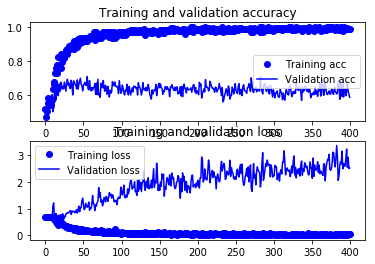

In [151]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


f, (ax1,ax2) = plt.subplots(2,1)

epochs = range(len(acc))

ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()


ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.show()
